# Attention Matrix Factorization

In [12]:
import torch

## Data

In [13]:
from gcn.data import read_data_ml100k, split_data_ml100k, load_data_ml100k
ratings_df, num_users, num_items = read_data_ml100k("./data/ml-latest-small")
train_data, test_data = split_data_ml100k(ratings_df, num_users, 'seq-aware', test_ratio=0.1)
users_train, items_train, ratings_train, train_candidates = load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit"
) # train_candidates is a dict of {user: [items]}
users_test, items_test, ratings_test, test_candidates = load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit"
) # test_candidates is a dict of {user: [items]}

In [14]:
train_data.head()

,0,1,2,3
0,1,633,4.0,964980499
1,1,911,5.0,964980499
2,1,1493,5.0,964980523
3,1,1979,4.0,964980523
4,1,2126,4.0,964980523


In [15]:
len(train_data)

100226

In [16]:
test_data.head()

,0,1,2,3
0,1,1874,4.0,965719662
1,2,7399,4.5,1445715340
2,3,1824,0.5,1306464293
3,4,3153,4.0,1007574542
4,5,212,5.0,847435337


In [17]:
len(test_data)

610

In [18]:
import random
class PRDataset(torch.utils.data.Dataset):
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set([i for i in range(num_items)])

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]

In [19]:
batch_size = 1024
trainset = PRDataset(users_train, items_train, train_candidates, num_items)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [20]:
len(train_loader)

98

## Model Config

In [21]:
from gcn.models import AttentionMF
from gcn.loss import BPRLoss
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 10
model = AttentionMF(num_users, num_items, n_factors)
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss_fn = BPRLoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 10, learning_rate: 0.01, weight_decay: 1e-05


## Train

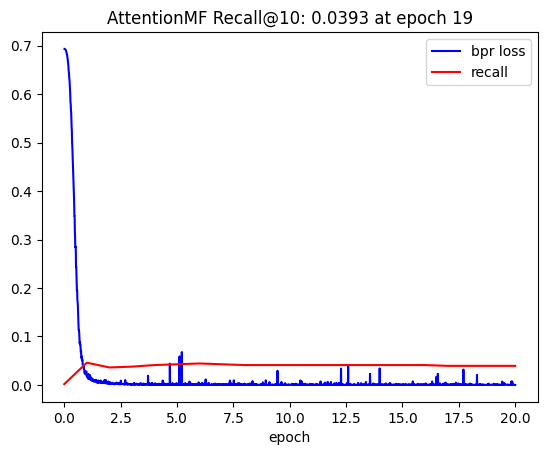

AttentionMF Recall@10: 0.0393 at epoch 19


In [22]:
from gcn.train import evaluate_ranking
from gcn.visualize import Animator
ani = Animator()
num_epochs = 20
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        input_data = []
        for v in values:
            input_data.append(v.to(device))

        p_pos = model(input_data[0], input_data[1])
        p_neg = model(input_data[0], input_data[-1])
        loss = loss_fn(p_pos, p_neg)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        epoch_list.append(epoch+1)


    scheduler.step()

    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='bpr loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'AttentionMF Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'AttentionMF Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')

ani.close()

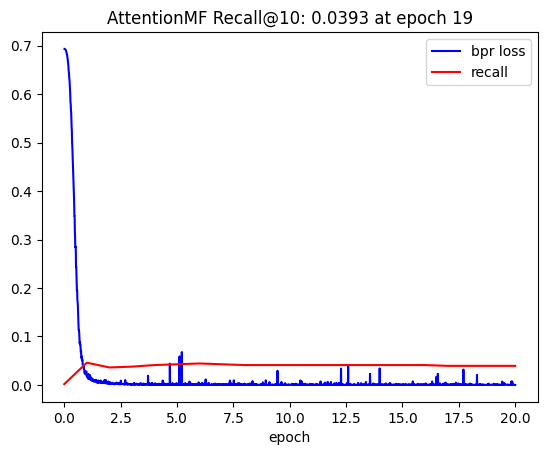

In [23]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='bpr loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.xlabel("epoch")
plt.legend()
plt.title(f'AttentionMF Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')
plt.show()

In [24]:
recall_list

[0.001639344262295082,
 0.04590163934426229,
 0.036065573770491806,
 0.03770491803278689,
 0.040983606557377046,
 0.04262295081967213,
 0.04426229508196721,
 0.04262295081967213,
 0.040983606557377046,
 0.040983606557377046,
 0.040983606557377046,
 0.040983606557377046,
 0.040983606557377046,
 0.040983606557377046,
 0.040983606557377046,
 0.040983606557377046,
 0.040983606557377046,
 0.03934426229508197,
 0.03934426229508197,
 0.03934426229508197,
 0.03934426229508197]

In [25]:
# max(recall_list), min(rmse_list) 
print(f'AttentionMF Max Recall@{topk}: {max(recall_list):.4f} at epoch {recall_list.index(max(recall_list))}')

AttentionMF Max Recall@10: 0.0459 at epoch 1
